In [61]:
# !pip install konlpy
# !pip install wheel
# !pip install JPype1-1.1.2-cp37-cp37m-win_amd64.whl

In [1]:
from wordcloud import WordCloud

In [2]:
import pandas as pd
import numpy as np
import konlpy
import re

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from sklearn.feature_extraction.text import CountVectorizer   # tf-idf 방식을 사용하려면 대신 TfidfVectorizer를 import
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [4]:
from konlpy.tag import Okt

In [5]:
import sys
print(sys.version)

3.7.6 (default, Jan  8 2020, 20:23:39) [MSC v.1916 64 bit (AMD64)]


In [6]:
konlpy.__version__

'0.5.2'

In [7]:
okt = Okt()

In [8]:
reviews_df = pd.read_csv('rating_df.csv', encoding='utf-8', index_col=0, parse_dates=['Timestamp'])
reviews_df.head()

,review_code,place_code,ItemID,UserID,review,Rating,Timestamp
0,SB000001,STORE_SB0001,성북동메밀수제비누룽지백숙,te9a7m,너무비싸,2.0,2021-08-08
1,SB000002,STORE_SB0001,성북동메밀수제비누룽지백숙,7kup8e,맛은 좋으나 기다림이 문제,3.0,2021-07-14
2,SB000003,STORE_SB0001,성북동메밀수제비누룽지백숙,fkfake,NaN,3.0,2021-06-26
3,SB000004,STORE_SB0001,성북동메밀수제비누룽지백숙,g8k5fl,들깨수제비까지 욕심부리면 배터집니다. 백숙과 메일전이면 충분 남은 음식 포장 가능,4.0,2021-06-20
4,SB000005,STORE_SB0001,성북동메밀수제비누룽지백숙,n5mvk0,굿 애프터하이크 푸드,4.0,2021-05-23


In [9]:
reviews_df.shape

(15420, 7)

In [10]:
print(reviews_df.isna().sum())

review_code       0
place_code        0
ItemID            0
UserID         4592
review         2945
Rating         1412
Timestamp         0
dtype: int64


In [11]:
reviews = reviews_df.dropna(axis=0)

In [12]:
reviews.shape

(9086, 7)

In [13]:
reviews.head()

,review_code,place_code,ItemID,UserID,review,Rating,Timestamp
0,SB000001,STORE_SB0001,성북동메밀수제비누룽지백숙,te9a7m,너무비싸,2.0,2021-08-08
1,SB000002,STORE_SB0001,성북동메밀수제비누룽지백숙,7kup8e,맛은 좋으나 기다림이 문제,3.0,2021-07-14
3,SB000004,STORE_SB0001,성북동메밀수제비누룽지백숙,g8k5fl,들깨수제비까지 욕심부리면 배터집니다. 백숙과 메일전이면 충분 남은 음식 포장 가능,4.0,2021-06-20
4,SB000005,STORE_SB0001,성북동메밀수제비누룽지백숙,n5mvk0,굿 애프터하이크 푸드,4.0,2021-05-23
5,SB000006,STORE_SB0001,성북동메밀수제비누룽지백숙,1dtoiih,좋아 함. 그래서 자주 감. 근데 닭보다 누룽지가 훨 맛있음. 누룽지를 먹기 위해 ...,4.0,2021-05-13


In [14]:
# 텍스트를 tokenize해서 adjective, verb, noun만 추출하는 함수

def tokenize_korean_text(text): 
    text_filtered = re.sub('[^,.?!\w\s]','', text)

    okt = Okt() 
    Okt_morphs = okt.pos(text_filtered) 

    words = []
    for word, pos in Okt_morphs:
        if pos == 'Adjective' or pos == 'Verb' or pos == 'Noun':
            words.append(word)

    words_str = ' '.join(words)
    return words_str

In [15]:
X_texts = []
y = []

for star, comment in zip(reviews['Rating'], reviews['review']):
    
    tokenized_comment = tokenize_korean_text(comment)  # 위에서 만들었던 함수로 comment 쪼개기
    X_texts.append(tokenized_comment)
    
    y.append(1 if star > 3 else -1)
    # 평점이 8 이상이면(8,9,10) 값을 1로 지정 (positive)
    # 평점이 3 이하이면(1,2,3) 값을 -1로 지정 (negative)

print(f'원래 text 수: {len(reviews)}')
# print(f'평점 3 이하 혹은 8 이상인 text 수: {len(X_texts)}')
print(X_texts[:5])

원래 text 수: 9086
['비싸', '맛 좋으나 기다림 문제', '들깨 수제비 욕심 부리면 배 터집니다 백숙 메일 전이 충분 남은 음식 포장 가능', '굿 애프터 이크 푸드', '좋아 함 자주 감 닭 누룽지 훨 맛있음 누룽지 먹기 위해 닭백숙 시켜야 하는 슬픈 현실 센터 살코기 조금 넣고 누룽지 죽 메뉴 좀 파세요 인분 먹을 의향 있음']


In [46]:
X_texts[:10]

['비싸',
 '맛 좋으나 기다림 문제',
 '들깨 수제비 욕심 부리면 배 터집니다 백숙 메일 전이 충분 남은 음식 포장 가능',
 '굿 애프터 이크 푸드',
 '좋아 함 자주 감 닭 누룽지 훨 맛있음 누룽지 먹기 위해 닭백숙 시켜야 하는 슬픈 현실 센터 살코기 조금 넣고 누룽지 죽 메뉴 좀 파세요 인분 먹을 의향 있음',
 '누룽지 백숙 부드럽고 김치 동치미 맛 좋음 식사 후 리홀 뮤직 갤러리 음악 들으며 차 한잔 하는 것 이집 풀 코스',
 '가야 이유 쫄깃 백숙 구수한 누룽지 상당한 양 가는 이유 포장 하겠지만 삶는지 고기 쫄깃 담백하지만 껍질 싫어하는 사람 더 싫을듯 죽은 굉장히 걸쭉하고 누룽지 구수해서 좋음 누룽지 양 많아서 인분 하는게 맞을듯 메밀전 자리 셋팅되는 먼저 나와서 기다리는 동안 먹을 수 있어 좋고 맛 괜찮 일요일',
 '김치 재사용 하시나 봐요 김치 물티슈 비닐 나왔습니다 저희 물티슈 주지 않으셨습니다 확인 하시더니 비닐 게눈 감추듯 후다닥 처리 하시더라구요 맛있게 먹다 얼마나 열 받던지 사진 찍어 놓을걸 또 열 받네',
 '맛 변한건 가요 아래 들 알바 맛 없는데 내 그냥 삶아도 것 맛있을듯',
 '영업 시간 정보 잘못 되어 있네요 마감 주문 마감 부러 찾아가서 도착 했는데 영업 시간 찾아보고 온 거 잘못 왔다고 되려 성 내시길래 당황 했네요 인터넷 익숙 치 않으시다고 이해해 그럼 안 드시라고 성 내는 태도 찾아간 고객 인 가봐요 안 드시라면서 메밀전 안 시키냐고']

In [34]:
len(X_texts)

9086

In [114]:
vocab = {}
sentences = []

for text in X_texts:
    sentence = okt.nouns(text)
    
    for word in sentence:
        if word not in vocab:
            vocab[word] = 0
        vocab[word] += 1
    
    sentences.append(sentence)

print(sentences[:5])

[[], ['맛', '기다림', '문제'], ['들깨', '수제비', '욕심', '부리면', '배', '백숙', '메일', '전이', '충분', '음식', '포장', '가능'], ['굿', '애프터', '이크', '푸드'], ['함', '자주', '감', '닭', '누룽지', '훨', '누룽지', '먹기', '위해', '닭백숙', '현실', '센터', '살코기', '조금', '누룽지', '죽', '메뉴', '좀', '인분', '의향']]


In [103]:
# print(vocab)

In [115]:
vocab_sorted = sorted(vocab.items(), key = lambda x:x[1], reverse = True)
print(vocab_sorted[:5])

[('맛', 2501), ('가격', 888), ('곳', 737), ('진짜', 736), ('집', 657)]


In [78]:
import numpy as np

from PIL import Image
from wordcloud import WordCloud

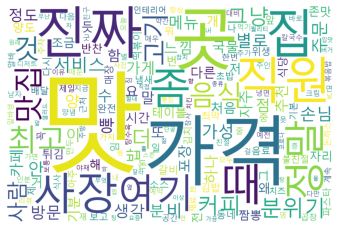

In [116]:
## 자신의 컴퓨터 환경에 맞는 한글 폰트 경로를 설정
font_path = 'TIL/K-digit/Project2/preprocessing/malgun.ttf'

good_mask = np.array(Image.open('cloud-re.png'))

wc = WordCloud(width = 1500, height = 1000, background_color="white", font_path=font_path)
wc = wc.generate_from_frequencies(dict(vocab_sorted))
wc.to_file('wordcloud.png')
# wc.generate_from_frequencies(dict(vocab_sorted))

plt.imshow(wc)
plt.axis("off")
plt.show()

(-0.5, 773.5, 321.5, -0.5)

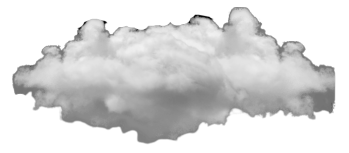

In [95]:
good_mask = np.array(Image.open('cloud-re.png'))

plt.imshow(good_mask)
plt.axis('off')

In [ ]:
# font_path = 'C:\\Windows\\Fonts\\HYGothic 중간.ttf'

# wc = WordCloud(width = 1000, height = 600, background_color="white", font_path=font_path)
# wc.generate(vocab_sorted)

In [ ]:
wc = WordCloud().generate(dict(vocab_sorted))

In [ ]:
wc.generate_from_frequencies(dict(vocab_sorted))

In [21]:
# train_test_split
X_train_texts, X_test_texts, y_train, y_test = train_test_split(X_texts, y, test_size=0.2, random_state=0)

In [22]:
# CountVectorizer로 vector화
tf_vectorizer = CountVectorizer(min_df=1, ngram_range=(1,1))
X_train_tf = tf_vectorizer.fit_transform(X_train_texts)  # training data에 맞게 fit & training data를 transform
X_test_tf = tf_vectorizer.transform(X_test_texts) # test data를 transform

vocablist = [word for word, number in sorted(tf_vectorizer.vocabulary_.items(), key=lambda x:x[1])]  # 단어들을 번호 기준 내림차순으로 저장

In [23]:
## 확인해보기
print(X_train_tf[:1], '\n')
print(X_test_tf[:1], '\n')
print(vocablist[:3])

  (0, 4980)	1
  (0, 8620)	1
  (0, 14701)	1
  (0, 5820)	1
  (0, 7470)	1
  (0, 13214)	1
  (0, 12503)	1
  (0, 5657)	1
  (0, 5803)	1
  (0, 980)	1
  (0, 3497)	1 

  (0, 15)	1
  (0, 544)	1
  (0, 1017)	1
  (0, 1530)	1
  (0, 1720)	1
  (0, 5439)	1
  (0, 5946)	1
  (0, 6932)	1
  (0, 6986)	1
  (0, 9004)	1
  (0, 9227)	1
  (0, 11152)	1
  (0, 11386)	1
  (0, 13214)	1
  (0, 13498)	1
  (0, 14506)	1
  (0, 14817)	1
  (0, 16424)	1 

['가게', '가게네요', '가게되']


In [24]:
model = LogisticRegression(C=0.1, penalty='l2', random_state=0)
model.fit(X_train_tf, y_train)  # 학습

LogisticRegression(C=0.1, random_state=0)

In [25]:
LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

LogisticRegression(C=0.1, random_state=0)

In [26]:
y_test_pred = model.predict(X_test_tf)

print('Misclassified samples: {} out of {}'.format((y_test_pred != y_test).sum(), len(y_test)))
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, y_test_pred)))  # model.score(X_test_tf, y_test)로 계산해도 됨

Misclassified samples: 325 out of 1818
Accuracy: 0.82


In [27]:
coefficients = model.coef_.tolist()

sorted_coefficients = sorted(enumerate(coefficients[0]), key=lambda x:x[1], reverse=True)
# coefficients(계수)가 큰 값부터 내림차순으로 정렬

print('긍정적인 단어 Top 10 (높은 평점과 상관관계가 강한 단어들)')
for word_num, coef in sorted_coefficients[:10]:
    print('{0:}({1:.3f})'.format(vocablist[word_num], coef))

print('\n부정적인 단어 Top 10 (낮은 평점과 상관관계가 강한 단어들)')
for word_num, coef in sorted_coefficients[-10:]: 
    print('{0:}({1:.3f})'.format(vocablist[word_num], coef))

긍정적인 단어 Top 10 (높은 평점과 상관관계가 강한 단어들)
맛있어요(1.783)
최고(1.522)
맛있고(1.158)
존맛(1.150)
좋아요(1.114)
친절하시고(0.933)
맛있음(0.907)
맛있었어요(0.887)
맛있습니다(0.885)
맛있네요(0.862)

부정적인 단어 Top 10 (낮은 평점과 상관관계가 강한 단어들)
시켰는데(-0.673)
마세요(-0.676)
실망(-0.680)
다신(-0.717)
없음(-0.748)
손님(-0.774)
그냥(-0.931)
최악(-1.076)
별로(-1.100)
불친절(-1.208)
